## 04b - The Many Variables & The Spurious Waffles

#### Imports

In [1]:
# ruff: noqa: F405
from init_notebook import *
from causalgraphicalmodels import CausalGraphicalModel
import daft as daft

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import pymc as pm

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-02-19T23:03:33.643496+04:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.32.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
matplotlib: 3.10.0
watermark : 2.5.0
arviz     : 0.20.0
pandas    : 2.2.3
pymc      : 5.20.1
scipy     : 1.12.0



#### Masked Relationship

The divorce rate example demonstrates that multiple predictor variables are useful for knocking out spurious association. A second reason to use more than one predictor variable is to measure the direct influences of multiple factors on an outcome, when none of those influences is apparent from bivariate relationships. This kind of problem tends to arise when there are two predictor variables that are correlated with one another. However, one of these is positively correlated with the outcome and the other is negatively correlated with it.

You’ll consider this kind of problem in a new data context, information about the composition of milk across primate species, as well as some facts about those species, like body mass and brain size. Milk is a huge investment, being much more expensive than gestation. Such an expensive resource is likely adjusted in subtle ways, depending upon the physiological and development details of each mammal species. 

In [2]:
d = pd.read_csv("data/milk.csv", sep=';')

You should see in the structure of the data frame that you have 29 rows for 8 variables. The variables we’ll consider for now are `kcal.per.g` (kilocalories of energy per gram of milk), `mass` (average female body mass, in kilograms), and `neocortex.perc` (percent of total brain mass that is neocortex mass).

A popular hypothesis has it that primates with larger brains produce more energetic milk, so that brains can grow quickly. Answering questions of this sort consumes a lot of effort in evolutionary biology, because there are many subtle statistical issues that arise when comparing species. It doesn’t help that many biologists have no reference model other than a series of regressions, and so the output of the regressions is not really interpretable. The causal meaning of statistical estimates always depends upon information outside the data.

We won’t solve these problems here. But we will explore a useful example. The question here is to what extent energy content of milk, measured here by kilocalories, is related to the percent of the brain mass that is neocortex. Neocortex is the gray, outer part of the brain that is especially elaborate in some primates. We’ll end up needing female body mass as well, to see the masking that hides the relationships among the variables. Let’s standardize these three variables. As in previous examples, standardizing helps us both get a reliable approximation of the posterior as well as build reasonable priors.

In [3]:
d['K'] = utils.standardize(d['kcal.per.g'])
d['N'] = utils.standardize(d['neocortex.perc'])
d['M'] = utils.standardize(d['mass'])

The first model to consider is the simple bivariate regression between kilocalories and neocortex percent. You already know how to set up this regression. In mathematical form:

$$
\begin{align*}
  K_i &\sim \text{Normal}(\mu_i,\sigma) \\
  \mu_i &= \alpha + \beta_N N_{i} \\
\end{align*}
$$

where $K$ is standardized kilocalories and $N$ is standardized neocortex percent. We still need to consider the priors but we will consider some vague priors for now. Before that, we note that `d.N` consists of `NaN` or missing values. If you pass a vector like this to a likelihood function like `pm.Normal`, it doesn’t know what to do. After all, what’s the probability of a missing value? Whatever the answer, it isn’t a number, and so `pm.Normal` returns a NaN. 

This is easy to fix. What you need to do here is manually drop all the cases with missing values. This is known as a **complete case analysis**. Some automated model fitting commands will silently drop such cases for you. But this isn’t always a good thing. First, it’s validity depends upon the process that caused these particular values to go missing. Later, we'll explore this in much more depth. Second, once you start comparing models, you must compare models fit to the same data. If some variables have missing values that others do not, automated tools will silently produce misleading comparisons. Let’s march forward for now, dropping any cases with missing values. It’s worth learning how to do this yourself. To make a new data frame with only complete cases, use:

In [4]:
dcc = d.dropna(subset=['K', 'N', 'M']).reset_index(drop=True)
dcc.shape

(17, 11)

This makes a new data frame, `dcc`, that consists of the 17 rows from `d` that have no missing values in any of the variables listed inside `df.dropna`. Now let’s work with the new data frame:

In [5]:
with pm.Model() as m5_5_draft:
    N = pm.ConstantData('N', dcc.N, dims='obs_id')
    
    a = pm.Normal('a', 0, 1)
    bN = pm.Normal('bN', 0, 1)
    sigma = pm.Exponential('sigma')
    
    mu = pm.Deterministic('mu', a + bN * N, dims='obs_id')
    
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=dcc.K, dims='obs_id')
    
    custom_step_m5_5 = utils.QuadraticApproximation([a, bN, sigma], m5_5_draft)
    idata_m5_5_draft = pm.sample(step=custom_step_m5_5, progressbar=False)

Multiprocess sampling (4 chains in 4 jobs)
QuadraticApproximation: [a, bN, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


Before considering the posterior predictions, let’s consider those priors. As in many simple linear regression problems, these priors are harmless. But are they reasonable? It is important to build reasonable priors, because as the model becomes less simple, the priors can be very helpful, but only if they are scientifically reasonable. To simulate and plot 50 prior regression lines:

In [6]:
with m5_5_draft:
    pm.set_data({'N': [-2,2]})
    idata_m5_5_draft.extend(pm.sample_prior_predictive())

Sampling: [K, a, bN, sigma]


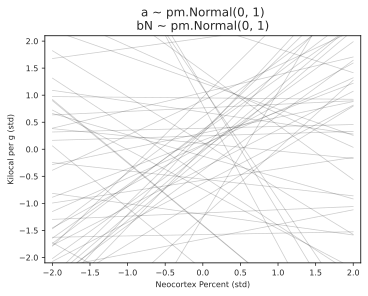

In [7]:
plt.plot([-2,2], az.extract(idata_m5_5_draft, 'prior').mu[:,:50], 'k', alpha=0.2)
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.xlabel('Neocortex Percent (std)')
plt.ylabel('Kilocal per g (std)')
plt.title('a ~ pm.Normal(0, 1)\nbN ~ pm.Normal(0, 1)');

We’ve shown a range of 2 standard deviations for both variables. So that is most of the outcome space. These lines are crazy. As in previous examples, we can do better by both tightening the $α$ prior so that it sticks closer to zero. With two standardized variables, when predictor is zero, the expected value of the outcome should also be zero. And the slope $β_N$ needs to be a bit tighter as well, so that it doesn’t regularly produce impossibly strong relationships. Here’s an attempt:

In [8]:
with pm.Model() as m5_5:
    N = pm.ConstantData('N', dcc.N, dims='obs_id')
    
    a = pm.Normal('a', 0, 0.2)
    bN = pm.Normal('bN', 0, 0.5)
    sigma = pm.Exponential('sigma')
    
    mu = pm.Deterministic('mu', a + bN * N, dims='obs_id')
    
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=dcc.K, dims='obs_id')
    
    custom_step_m5_5 = utils.QuadraticApproximation([a, bN, sigma], m5_5)
    idata_m5_5 = pm.sample(step=custom_step_m5_5, progressbar=False)

Multiprocess sampling (4 chains in 4 jobs)
QuadraticApproximation: [a, bN, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [9]:
with m5_5:
    pm.set_data({'N': [-2,2]})
    idata_m5_5.extend(pm.sample_prior_predictive())

Sampling: [K, a, bN, sigma]


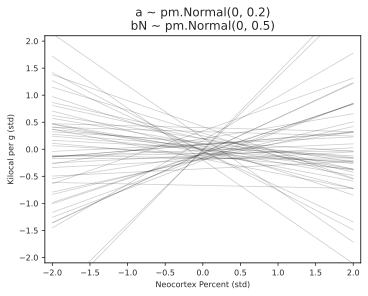

In [10]:
plt.plot([-2,2], az.extract(idata_m5_5, 'prior').mu[:,:50], 'k', alpha=0.2)
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.xlabel('Neocortex Percent (std)')
plt.ylabel('Kilocal per g (std)')
plt.title('a ~ pm.Normal(0, 0.2)\nbN ~ pm.Normal(0, 0.5)');

The modified priors produces the above plot. These are still very vague priors, but at least the lines stay within the high probability region of the observable data.

Now let's look at the posterior:

In [11]:
az.summary(idata_m5_5, var_names=['~mu'], kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.040,0.160,-0.221,0.284
bN,0.132,0.220,-0.198,0.501
sigma,1.009,0.168,0.715,1.249


From this summary, you can possibly see that this is neither a strong nor very precise association. The standard deviation is almost twice the posterior mean. But as always, it’s much easier to see this if we draw a picture. We can plot the predicted mean and 89% compatibility interval for the mean to see this more easily. The code below contains no surprises.

Sampling: [K]


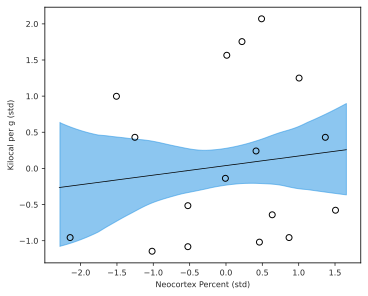

In [12]:
xseq = np.linspace(dcc.N.min()-0.15, dcc.N.max()+0.15, 30)

with m5_5:
    pm.set_data({'N': xseq})
    idata_m5_5_posterior_pred = pm.sample_posterior_predictive(idata_m5_5, var_names=["mu", 'K'], progressbar=False)

mu_ppd = idata_m5_5_posterior_pred.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=['chain', 'draw'])

az.plot_hdi(xseq, mu_ppd, hdi_prob=0.89)
plt.plot(xseq, mu_mean, c="black")
plt.plot(dcc.N, dcc.K, 'o', fillstyle='none')
plt.xlabel("Neocortex Percent (std)")
plt.ylabel("Kilocal per g (std)");

The posterior mean line is weakly positive, but it is highly imprecise. A lot of mildly positive and negative slopes are plausible, given this model and these data.

Now consider another predictor variable, adult female body mass, `mass` in the data frame. Let’s use the logarithm of mass, `np.log(mass)`, as a predictor as well. Why the logarithm of mass instead of the raw mass in kilograms? It is often true that *scaling measurements like body mass are related by magnitudes to other variables*. Taking the *log of a measure translates the measure into magnitudes*. So by using the logarithm of body mass here, we’re saying that we suspect that the magnitude of a mother’s body mass is related to milk energy, in a linear fashion. Much later, we’ll see why these logarithmic relationships are almost inevitable results of the physics of organisms.

Now we construct a similar model, but consider the bivariate relationship between kilocalories and body mass. Since body mass is also standardized, we can use the same priors and stay within possible outcome values. But if you were a domain expert in growth, you could surely do better than this.

In [13]:
dcc['MLog'] = utils.standardize(np.log(dcc.mass))

In [14]:
with pm.Model() as m5_6:
    M = pm.ConstantData('M', dcc.MLog, dims='obs_id')
    
    a = pm.Normal('a', 0, 0.2)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma')
    
    mu = pm.Deterministic('mu', a + bM * M, dims='obs_id')
    
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=dcc.K, dims='obs_id')
    
    custom_step_m5_6 = utils.QuadraticApproximation([a, bM, sigma], m5_6)
    idata_m5_6 = pm.sample(step=custom_step_m5_6, progressbar=False)

az.summary(idata_m5_6, var_names=['~mu'], hdi_prob=0.89, kind='stats')

Multiprocess sampling (4 chains in 4 jobs)
QuadraticApproximation: [a, bM, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.037,0.159,-0.213,0.291
bM,-0.309,0.212,-0.650,0.022
sigma,0.971,0.157,0.721,1.232


Sampling: [K]


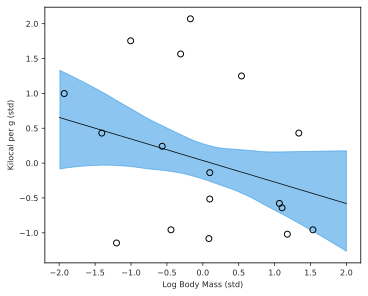

In [15]:
xseq = np.linspace(-2, 2, 30)

with m5_6:
    pm.set_data({'M': xseq})
    idata_m5_6_posterior_pred = pm.sample_posterior_predictive(idata_m5_6, var_names=["mu", 'K'], progressbar=False)

mu_ppd = idata_m5_6_posterior_pred.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=['chain', 'draw'])

az.plot_hdi(xseq, mu_ppd, hdi_prob=0.89)
plt.plot(xseq, mu_mean, c="black")
plt.plot(dcc.MLog, dcc.K, 'o', fillstyle='none')
plt.xlabel("Log Body Mass (std)")
plt.ylabel("Kilocal per g (std)");

Log-mass is negatively associated with kilocalories. This association does seem stronger than that of neocortex percent, although in the opposite direction. It is quite uncertain though, with a wide compatibility interval that is consistent with a wide range of both weak and stronger relationships.